In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [7]:
df['offer'].unique()

array([1, 0], dtype=object)

In [8]:
df.loc[(df.offer == 'No Offer'), 'offer'] = 0
df.loc[(df.offer == 'Buy One Get One'), 'offer'] = 1
df.loc[(df.offer == 'Discount'), 'offer'] = 1
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [9]:
df.rename(columns={'conversion': 'target'}, inplace=True)
df.rename(columns={'offer': 'treatment'}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [17]:
indices_learn, indices_valid = train_test_split(df.index, test_size=0.33, random_state=42)

In [18]:
indices_learn

Int64Index([44233, 58749, 56296, 23444, 48936, 14068, 57313, 11433, 40231,
            15625,
            ...
             6265, 54886, 11284, 44732, 54343, 62570, 38158,   860, 15795,
            56422],
           dtype='int64', length=42880)

In [20]:
X_train = df.loc[indices_learn, :]
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :]
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']

indices_train = df.index
X_train_full = df.loc[indices_train, :]
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']


cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': []
}

uplift@30%: 0.2206
uplift@20%: 0.3305
uplift@10%: 0.0000


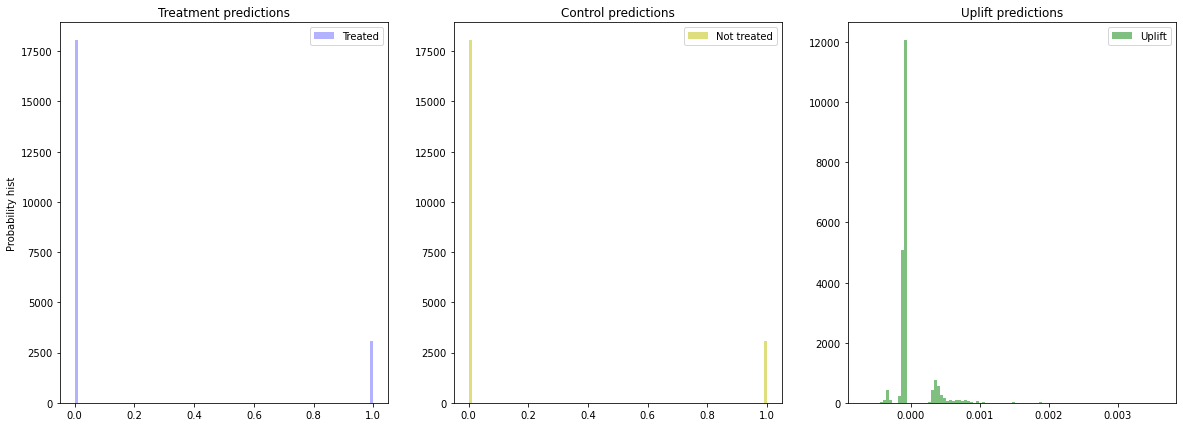

In [30]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')


models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [36]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {ct_score:.4f}')
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {ct_score:.4f}')
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {ct_score:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

uplift@30%: 0.5608
uplift@20%: 0.8411
uplift@10%: 1.0000


uplift@30%: 0.2150
uplift@20%: 0.3086
uplift@10%: 0.0791


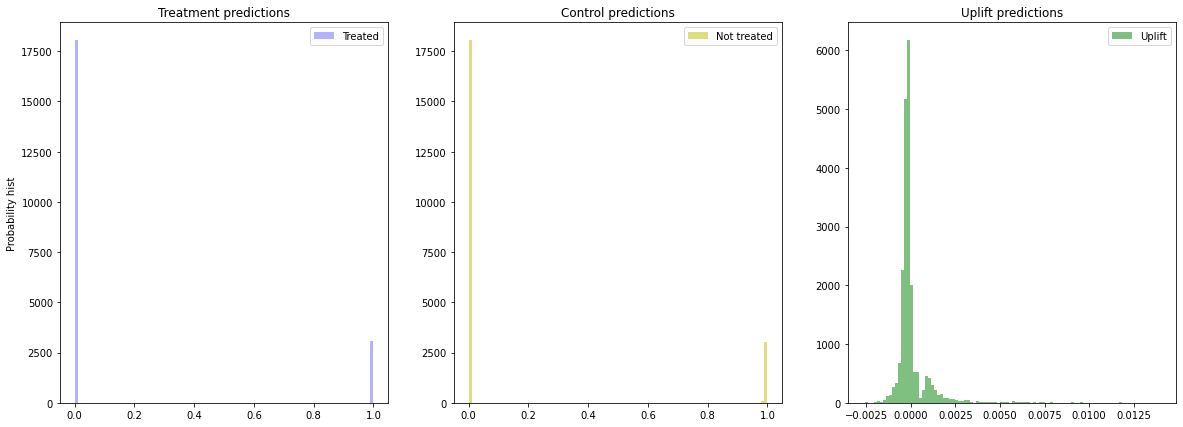

In [34]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {tm_score:.4f}')
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {tm_score:.4f}')
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {tm_score:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [39]:
X_train_tree = df
features = [col for col in X_train_tree]

In [40]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference'

In [43]:
!pip install causalml

  Using cached causalml-0.11.1.tar.gz (243 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
  Using cached causalml-0.11.0.tar.gz (239 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached causalml-0.10.0.tar.gz (235 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.18.5.zip (5.4 MB)
  Installing build dependencies

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\vol-wkst1084\appdata\local\programs\python\python39\python.exe' 'c:\users\vol-wkst1084\appdata\local\programs\python\python39\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' prepare_metadata_for_build_wheel 'C:\Users\VOL-WK~1\AppData\Local\Temp\tmpefdqr4mv'
       cwd: C:\Users\VOL-WKST1084\AppData\Local\Temp\pip-install-f7s9o_nj\scipy_1653d088bef64345a8626470e409d9a0
  Complete output (60 lines):
  setup.py:418: UserWarning: Unrecognized setuptools command ('dist_info --egg-base C:\Users\VOL-WKST1084\AppData\Local\Temp\pip-modern-metadata-hmswhlcp'), proceeding with generating Cython sources and expanding templates
    warnings.warn("Unrecognized setuptools command ('{}'), proceeding with "
  Running from scipy source directory.
  Could not locate executable g77
  Could not locate executable f77
  Could not locate executable ifort
  Could not locate executable ifl
  Could not locate executable f90
 

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\vol-wkst1084\appdata\local\programs\python\python39\python.exe' 'c:\users\vol-wkst1084\appdata\local\programs\python\python39\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' prepare_metadata_for_build_wheel 'C:\Users\VOL-WK~1\AppData\Local\Temp\tmpbmz8iqve'
       cwd: C:\Users\VOL-WKST1084\AppData\Local\Temp\pip-install-vx0fgahh\scipy_99c9b3688bda4af58abe7fd37e86e1a1
  Complete output (60 lines):
  setup.py:418: UserWarning: Unrecognized setuptools command ('dist_info --egg-base C:\Users\VOL-WKST1084\AppData\Local\Temp\pip-modern-metadata-78avdnm5'), proceeding with generating Cython sources and expanding templates
    warnings.warn("Unrecognized setuptools command ('{}'), proceeding with "
  Running from scipy source directory.
  Could not locate executable g77
  Could not locate executable f77
  Could not locate executable ifort
  Could not locate executable ifl


  Using cached causalml-0.11.1.tar.gz (243 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached scipy-1.4.1.tar.gz (24.6 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build


  Could not locate executable f90
  Could not locate executable DF
  Could not locate executable efl
  Built by Equation Solution <http://www.Equation.com>.
  Using built-in specs.
  COLLECT_GCC=C:\Users\VOL-WKST1084\gcc\bin\gfortran.exe
  COLLECT_LTO_WRAPPER=c:/users/vol-wkst1084/gcc/bin/../libexec/gcc/x86_64-w64-mingw32/9.2.0/lto-wrapper.exe
  Target: x86_64-w64-mingw32
  Configured with: ../gcc-9.2.0-mingw/configure --host=x86_64-w64-mingw32 --build=x86_64-unknown-linux-gnu --target=x86_64-w64-mingw32 --prefix=/home/gfortran/gcc-home/binary/mingw32/native/x86_64/gcc/9.2.0 --with-sysroot=/home/gfortran/gcc-home/binary/mingw32/cross/x86_64/gcc/9-20190310 --with-gcc --with-gnu-ld --with-gnu-as --with-ld64=no --with-gmp=/home/gfortran/gcc-home/binary/mingw32/native/x86_64/gmp --with-mpfr=/home/gfortran/gcc-home/binary/mingw32/native/x86_64/mpfr --with-mpc=/home/gfortran/gcc-home/binary/mingw32/native/x86_64/mpc --with-cloog=/home/gfortran/gcc-home/binary/mingw32/native/x86_64/cloog --w

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
  Using cached causalml-0.11.0.tar.gz (239 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached causalml-0.10.0.tar.gz (235 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.18.5.zip (5.4 MB)
  Installing build dependencies: started
  Installing build dependencies: fini